In [1]:
import os
import sys

PROJECT_ROOT = os.path.join(os.path.abspath(os.path.dirname('./../../')), 'src')

sys.path.append(PROJECT_ROOT)

import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

In [2]:
from data_utils import *
from config import Config
from matplotlib import pyplot as plt

**Load data**

In [3]:
%%time
cfg = Config()
ds = DataSource(cfg['data_source'])
ds.read_data()
ds.validation_split()

Reading groups_desc...
Reading train_x...
Reading test_x...
Reading train_target...
Reading test_target...
Validation split: by clientID
CPU times: user 26.7 s, sys: 5.38 s, total: 32.1 s
Wall time: 21.1 s


In [5]:
cfg['data_source'].keys()

dict_keys(['groups_desc', 'train_x', 'test_x', 'train_target', 'test_target'])

In [6]:
print(ds)

Dataset: groups_desc, shape: (204, 2)
Dataset: train_x, shape: (21295142, 4)
Dataset: test_x, shape: (17667328, 4)
Dataset: train_target, shape: (24145, 2)
Dataset: test_target, shape: (20000, 1)
Dataset: valid_x, shape: (5155435, 4)
Dataset: valid_target, shape: (5855, 2)


**Groups descriptions**

In [7]:
groups = ds.get_data('groups_desc')
groups

,small_group,small_group_code
0,Зоотовары,0
1,Сетевые супермаркеты и продуктовые магазины,1
2,Обслуживание существующего автомобиля (АЗС),2
3,Оплата телефона и связи,3
4,Аптеки,4
5,Авиабилеты,5
6,Duty-free,6
7,Страховка,7
8,Спорт,8
9,Универсальные товары,9


**Train target**

In [8]:
train_target = ds.get_data('train_target')
print(train_target.shape)
train_target.head()

(24145, 2)


,client_id,bins
0,1046,0
1,34089,2
2,34848,1
3,47076,3
4,10938,2


Train clientID distribution

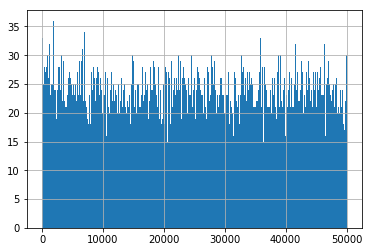

In [10]:
train_target.client_id.hist(bins=1000);

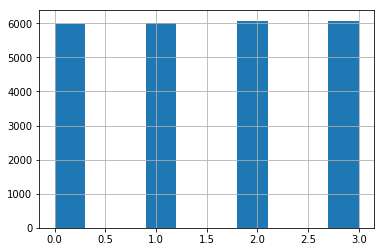

In [12]:
train_target.bins.hist();

**Train transactions**

In [13]:
train_x = ds.get_data('train_x')
train_x.shape

(21295142, 4)

In [14]:
train_x.head()

,client_id,trans_date,small_group,amount_rur
0,3694,26,1,10.006
1,3694,29,3,54.955
2,3694,31,1,10.945
3,3694,34,36,61.721
4,3694,36,25,4.579


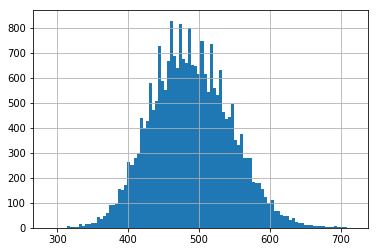

In [15]:
train_x.groupby('client_id').trans_date.nunique().hist(bins=100);

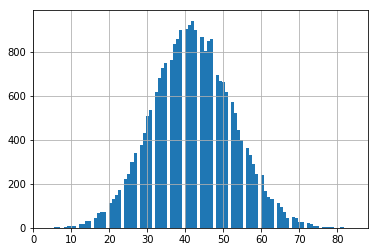

In [16]:
train_x.groupby('client_id').small_group.nunique().hist(bins=100);

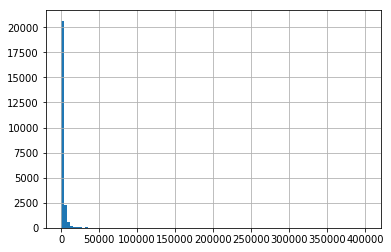

In [17]:
train_x.groupby('client_id').amount_rur.max().hist(bins=100);

Number of clients which spent huge amounts of money in a single transaction

In [18]:
train_x[train_x.amount_rur > 30000].client_id.nunique()

200

Some groups are popular, some are not

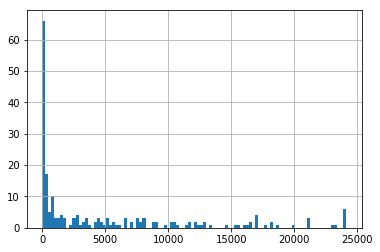

In [19]:
train_x.groupby('small_group').client_id.nunique().hist(bins=100)